In [1]:
import pandas as pd
pd.set_option("display.max_colwidth", None)
import numpy as np
import pickle
import logging
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
from time import time
import os
import re
import csv
from gensim.models import Word2Vec
import multiprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
#load training data

In [2]:
train_data = pickle.load(open("training_data.pkl", "rb"))
train_data.shape

(17000, 6)

In [3]:
train_data.head()

,id,polarity,tweet,caps_share,cleaned_tweet,emojis
0,4330,neutral,nen á vist bolest vztek smutek zmatek osam ě lost beznad ě j a nakonec jen klid Asi takhle vypad á m ů j life ...,0.011236,nen vist bolest vztek smutek zmatek osam lost beznad nakonec jen klid asi takhle vypad life,
1,41616,neutral,@ nehantics Haan yaar neha 😔😔 kab karega woh post 😭 Usne na sach mein photoshoot karna chahiye phir woh post karega … https // tco / 5RSlSbZNtt,0.059829,haan yaar neha kab karega woh post usne na sach mein photoshoot karna chahiye phir woh post karega,loudly_crying_face pensive_face pensive_face
2,6648,negative,@ RahulGandhi television media congress ke liye nhi h . Ye toh aapko pata chal hi gya hoga . Achha hoga ki Congress ke … https // t . co / HmH8M7PTaK,0.092437,television media congress ke liye nhi ye toh aapko pata chal hi gya hoga achha hoga ki congress ke,
3,2512,positive,@ AmitShah @ narendramodi All India me nrc lagu kare w Kashmir se dhara 370ko khatam kare ham Indian ko apse yahi umid hai,0.060000,all india me nrc lagu kare kashmir se dhara khatam kare ham indian ko apse yahi umid hai,
4,610,neutral,@ Nehr _ who @ TypoMantri @ anjanaomkashyap Pagal hai kya ? They aren ’ t real issues Mandir is important Hindu khatre mei jo hai !,0.066038,pagal hai kya they are not real issues mandir is important hindu khatre mei jo hai,


In [7]:
#encoding categorical polarities into numerical

In [4]:
LE = LabelEncoder()
train_data["polarity"] = LE.fit_transform(train_data["polarity"])

In [5]:
train_data.head()

,id,polarity,tweet,caps_share,cleaned_tweet,emojis
0,4330,1,nen á vist bolest vztek smutek zmatek osam ě lost beznad ě j a nakonec jen klid Asi takhle vypad á m ů j life ...,0.011236,nen vist bolest vztek smutek zmatek osam lost beznad nakonec jen klid asi takhle vypad life,
1,41616,1,@ nehantics Haan yaar neha 😔😔 kab karega woh post 😭 Usne na sach mein photoshoot karna chahiye phir woh post karega … https // tco / 5RSlSbZNtt,0.059829,haan yaar neha kab karega woh post usne na sach mein photoshoot karna chahiye phir woh post karega,loudly_crying_face pensive_face pensive_face
2,6648,0,@ RahulGandhi television media congress ke liye nhi h . Ye toh aapko pata chal hi gya hoga . Achha hoga ki Congress ke … https // t . co / HmH8M7PTaK,0.092437,television media congress ke liye nhi ye toh aapko pata chal hi gya hoga achha hoga ki congress ke,
3,2512,2,@ AmitShah @ narendramodi All India me nrc lagu kare w Kashmir se dhara 370ko khatam kare ham Indian ko apse yahi umid hai,0.060000,all india me nrc lagu kare kashmir se dhara khatam kare ham indian ko apse yahi umid hai,
4,610,1,@ Nehr _ who @ TypoMantri @ anjanaomkashyap Pagal hai kya ? They aren ’ t real issues Mandir is important Hindu khatre mei jo hai !,0.066038,pagal hai kya they are not real issues mandir is important hindu khatre mei jo hai,


In [12]:
#creating vector to represent the count of all emojis in a tweet, given that the emoji occurs at least 5 times
#in the whole corpus

In [6]:
vectorizer = CountVectorizer(min_df = 5)
emojis = vectorizer.fit_transform(train_data["emojis"])
emojis_array = emojis.toarray()
emojis_array.shape

(17000, 162)

In [19]:
#loading trained word2vec model to create feature vectors for tweets

In [7]:
wv_model = pickle.load(open("wv_model.pkl", "rb"))
wv = wv_model.wv

In [32]:
#vectorizing the training set

In [8]:
t = time()
corpus_mat = np.empty((0, 300))
for tweet in train_data["cleaned_tweet"]:
    tweet_mat = np.empty((300, 0))
    for word in tweet.split():
        if word in wv.key_to_index.keys():
            tweet_mat = np.column_stack([tweet_mat, wv[word]])
        else:
            tweet_mat = np.column_stack([tweet_mat, np.zeros(300)])
    tweet_vec = np.mean(tweet_mat, axis = 1)
    corpus_mat = np.vstack([corpus_mat, tweet_vec])
corpus_mat = np.column_stack([corpus_mat, emojis_array])
corpus_mat = np.column_stack([corpus_mat, train_data["caps_share"].values])
corpus_mat = np.column_stack([corpus_mat, train_data["polarity"].values])
print("time taken: {} mins".format(round((time() - t)/60, 2)))

C:\Users\rahul\miniconda3\envs\thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rahul\miniconda3\envs\thesis\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


time taken: 2.53 mins


In [ ]:
#Defining our classifier pipeline which will normalise our data, train on it and predict the polarity when fed new data.
#We replace any missing values with 0.
#We use power transformation on the 300 columns which are the word2vec vectors to ensure they are as close to Gaussian
#as possible. This prevents the classifier from putting too much weight on features that have a much higher variance.
#We define a parameter grid on which to run Grid Search.

In [9]:
vector_preprocess = Pipeline(
    [("impute values", SimpleImputer(missing_values = np.nan, strategy = "constant", fill_value = 0)),
     ("scaler", PowerTransformer())])

preprocessor = ColumnTransformer(
    [("vector_preprocess", vector_preprocess, slice(0, 300))], remainder = "passthrough")

pipe = Pipeline(
    [("preprocessor", preprocessor), ("svc", SVC(class_weight = "balanced", random_state = 42, \
                                                 decision_function_shape = "ovr", break_ties = True))],
    memory = "SVC")

param_grid = [
    {"svc__kernel": ["rbf"],
    "svc__C": [0.01, 0.1, 0.5, 1, 2, 5, 10, 100],
    "svc__gamma": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
]

In [24]:
#defining x and y for training

In [10]:
x = corpus_mat[:, :-1]
y = corpus_mat[:, -1]
print(x.shape, y.shape)

(17000, 463) (17000,)


In [27]:
#implementing 5-fold cross validation on previously defined grid

In [11]:
t = time()
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
search = GridSearchCV(
    pipe,
    param_grid = param_grid,
    scoring = "f1_weighted",
    n_jobs = -4,
    cv = cv,
    refit = True,
    verbose = 1.5)
result = search.fit(x, y)
best_model = result.best_estimator_
best_params = result.best_params_
print("best params are: {}".format(result.best_params_))
print("time taken: {} mins".format(round((time() - t)/60, 2)))

Fitting 5 folds for each of 56 candidates, totalling 280 fits


C:\Users\rahul\miniconda3\envs\thesis\lib\site-packages\sklearn\pipeline.py:348: UserWarning: Persisting input arguments took 0.71s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


best params are: {'svc__C': 2, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
time taken: 686.44 mins


In [28]:
#choosing the model with highest average accuracy across the 5 folds as our final model

In [12]:
pipe = best_model

In [13]:
pipe

Pipeline(memory='SVC',
         steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vector_preprocess',
                                                  Pipeline(steps=[('impute '
                                                                   'values',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  slice(0, 300, None))])),
                ('svc',
                 SVC(C=2, break_ties=True, class_weight='balanced', gamma=0.001,
                     random_state=42))])

In [14]:
_params = best_params

In [15]:
_params

{'svc__C': 2, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}

In [29]:
#training classifier on the entire training data

In [16]:
t = time()
pipe.fit(x, y)
print("time taken: {} mins".format(round((time() - t)/60, 2)))

time taken: 1.72 mins


In [33]:
#loading the test data

In [17]:
test_data = pickle.load(open("test_data.pkl", "rb"))
test_data.shape

(3000, 5)

In [18]:
test_data.head()

,id,tweet,caps_share,cleaned_tweet,emojis
0,20803,@ 454dkhan @ Heisunberg _ Agr kse ko itni importantce chaeay ni tou ðŸ˜…,0.033333,kse ko itni importantce chaeay ni tou,
1,20187,logon ko alloo pyaz tomator me toh allah pak ka naam nazar aa jata hai pr aankhon k samne allah pak ke bande nazar â€¦ https // t . co / hBg7zS0viy,0.017094,logon ko alloo pyaz tomator me toh allah pak ka naam nazar aa jata hai pr aankhon samne allah pak ke bande nazar,
2,20953,@ LambaAlka Wafadaar bane rahane ka nayab tarika hai lamba ji aap us party se Judi hai jiska sardar @ ArvindKejriwal â€¦ https // t . co / krVTd1ZAEK,0.098361,wafadaar bane rahane ka nayab tarika hai lamba ji aap us party se judi hai jiska sardar,
3,13777,@ varnishant @ narendramodi Chup bhosdike . He has been exonerated of all the charges . Tum log ghanta prove nahi kar paaye .,0.029126,chup bhosdike he has been exonerated of all the charges tum log ghanta prove nahi kar paaye,
4,20990,RT @ HardeepSPuri à¨¦à¨¾à¨¤à¨¾ à¨¸à©‹ à¨¸à¨¾à¨²à¨¾à¨¹à©€à¨ à¨œà¨¿ à¨¸à¨­à¨¸à©ˆ à¨¦à©‡ à¨†à¨§à¨¾à¨°à© à¥¥ Praise the Great Giver who gives sustenance to all . Paid obeisance at Gurudwara Sr â€¦,0.065089,praise the great giver who gives sustenance to all paid obeisance at gurudwara sr,copyright copyright copyright copyright copyright


In [37]:
#creating emojis array for test data

In [19]:
test_emojis = vectorizer.transform(test_data["emojis"])
test_emojis_array = test_emojis.toarray()
test_emojis_array.shape

(3000, 162)

In [21]:
#vectorizing the test data

In [20]:
t = time()
test_mat = np.empty((0, 300))
for tweet in test_data["cleaned_tweet"]:
    tweet_mat = np.empty((300, 0))
    for word in tweet.split():
        if word in wv.key_to_index.keys():
            tweet_mat = np.column_stack([tweet_mat, wv[word]])
        else:
            tweet_mat = np.column_stack([tweet_mat, np.zeros(300)])
    tweet_vec = np.mean(tweet_mat, axis = 1)
    test_mat = np.vstack([test_mat, tweet_vec])
test_mat = np.column_stack([test_mat, test_emojis_array])
test_mat = np.column_stack([test_mat, test_data["caps_share"].values])
print("time taken: {} mins".format(round((time() - t)/60, 2)))

C:\Users\rahul\miniconda3\envs\thesis\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rahul\miniconda3\envs\thesis\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


time taken: 0.22 mins


In [42]:
#loading true labels for the test data

In [21]:
labels = []
with open("test_labels.txt", "r") as f:
    labels_file = csv.reader(f, delimiter = ",")
    for row in labels_file:
        if row != "":
            labels.append(row[1])

In [22]:
y_true = np.array(labels)
y_true = LE.fit_transform(y_true)

In [23]:
y_true

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

In [24]:
#predicting class for all tweets in the test dataset

In [25]:
t = time()
y_predict = pipe.predict(test_mat)
print("time taken: {} mins".format(round((time() - t)/60, 2)))

time taken: 0.33 mins


In [49]:
#finding out accuracy measure of the classifier

In [26]:
score = f1_score(y_true, y_predict, average = "weighted")
score

0.6756061023191975

In [58]:
#plotting confusion matrix

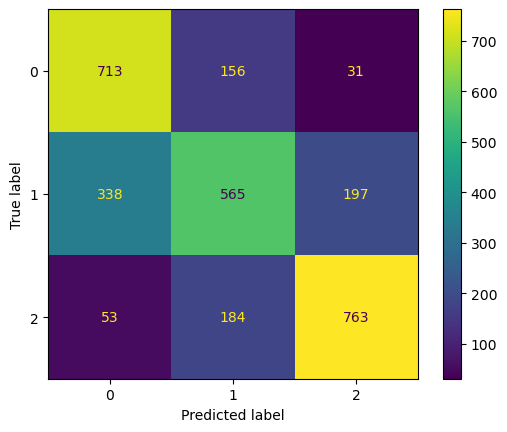

In [27]:
CM = ConfusionMatrixDisplay.from_predictions(y_true, y_predict)

In [28]:
CM.figure_.savefig("confusion_matrix.png", bbox_inches = "tight")

In [29]:
#creating classification report

In [30]:
print(classification_report(y_true, y_predict))

              precision    recall  f1-score   support

           0       0.65      0.79      0.71       900
           1       0.62      0.51      0.56      1100
           2       0.77      0.76      0.77      1000

    accuracy                           0.68      3000
   macro avg       0.68      0.69      0.68      3000
weighted avg       0.68      0.68      0.68      3000



In [3]:
#adding the true y-values to the test set

In [31]:
test_mat = np.column_stack([test_mat, y_true])

In [1]:
#combining all the training and testing data and training the classifier with the best parameter combination
#on the combined data

In [32]:
all_data = np.vstack([corpus_mat, test_mat])
x = all_data[:, :-1]
y = all_data[:, -1]

In [33]:
x.shape, y.shape

((20000, 463), (20000,))

In [4]:
#defining the classifier based on the best parameter combination discovered by the grid-search cv

In [34]:
pipe = best_model

In [35]:
pipe

Pipeline(memory='SVC',
         steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vector_preprocess',
                                                  Pipeline(steps=[('impute '
                                                                   'values',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   PowerTransformer())]),
                                                  slice(0, 300, None))])),
                ('svc',
                 SVC(C=2, break_ties=True, class_weight='balanced', gamma=0.001,
                     random_state=42))])

In [ ]:
t = time()
pipe.fit(x, y)
print("time taken: {} mins".format(round((time() - t)/60, 2)))

In [5]:
#saving the trained classifier to disk

In [35]:
pickle.dump(pipe, open("classifier.pkl", "wb"))

In [6]:
#saving the emoji vectorizer to disk

In [36]:
pickle.dump(vectorizer, open("emoji vectorizer.pkl", "wb"))

In [7]:
#if you are replicating the entire thesis workflow, you must save both the classifier and the emoji vectorizer
# in the folder "Tweets Preprocessing"